## Natural Pandemics
### Maximum likelihood estimation
Reproduce maximum likelihood estimation performed in [Madhav et al.](https://www.cgdev.org/sites/default/files/estimated-future-mortality-pathogens-epidemic-and-pandemic-potential.pdf), with additional calculations of standard errors of the estimates and minimised negative log-likelihood function value.

In [1]:
from helpers import *
from new_helpers import * # new helper function created for this notebook
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
params = Params()

In [3]:
marani_xls = params.Natural.dataset.val
marani_df, disease_totals = load_and_preprocess_natural_data(marani_xls)

In [4]:
# check for missing values
missing = marani_df.isnull().sum()
print(missing)

Location                                  0
Start Year                                0
End Year                                  0
# deaths (thousands)                      0
World Population (thousands)              1
Relative Epidemic size (per mil)          1
Intensity (deaths per thousand/year)      1
Disease                                   0
References                                0
Notes                                   180
# deaths (raw)                            0
disease (total deaths)                    0
disease_total_deaths                      0
Exceedance Probability                    0
Duration                                  0
dtype: int64


In [5]:
# drop the row with unkown intensity
marani_df = marani_df.dropna(subset=["Intensity (deaths per thousand/year)"])
marani_df["Intensity (deaths per thousand/year)"].isna().sum()

0

In [6]:
marani_1e_5_df = marani_df[(marani_df["Intensity (deaths per thousand/year)"] > 1e-5) & (marani_df["Start Year"].between(1600, 1944))]
marani_1e_3_df = marani_df[(marani_df["Intensity (deaths per thousand/year)"] > 1e-3) & (marani_df["Start Year"].between(1600, 1944))]

In [7]:
x = "Intensity (deaths per thousand/year)"
data = marani_1e_3_df[x]
covariance_matrix, scale_mle, shape_mle, scale_se, shape_se, minimized_nll = find_gpd_mle(
    data, threshold = 0.001, find_std = True, return_nll = True)

In [8]:
# print results
print(f"MLE scale: {scale_mle}")
print(f"MLE shape: {shape_mle}")
print(f"Covariance matrix: {covariance_matrix}")
print(f"Minimized NLL: {minimized_nll}")

MLE scale: 0.011290005748011766
MLE shape: 1.3981001450194226
Covariance matrix: [[ 4.31563735e-06 -2.02662711e-04]
 [-2.02501808e-04  4.01412599e-02]]
Minimized NLL: -314.94507779709204


### Goodness-of-fit

In [9]:
sorted_data = marani_1e_5_df.sort_values(by='Intensity (deaths per thousand/year)', ascending=True)
exceedance_probs = 1 - np.arange(len(sorted_data)) / len(sorted_data)
sorted_data["Exceedance Probability"] = exceedance_probs
gpd_vals = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=0.001, sigma=scale_mle, xi=shape_mle)
sorted_data["GPD"] = gpd_vals

In [10]:
observed = sorted_data["Exceedance Probability"]
expected = 0.62*sorted_data["GPD"]
# R^2 value
r2 = 1 - sum((observed - expected)**2) / sum((observed - np.mean(observed))**2)
print(f'R^2 value: {r2}')
# kullback-leibler divergence
kl = stats.entropy(observed, expected)
print(f'Kullback-Leibler divergence: {kl}')
# chi2 test
chi2, p = goodness_of_fit(observed, expected, method = 'chi2')
print(f'for chi2 test: chi2={chi2}, p={p}')
# kolmogorov-smirnov test
D, p = goodness_of_fit(observed, expected, method = 'ks')
print(f'for Kolmogorov-Smirnov test: D={D}, p={p}')
# anderson-darling test
A, crit, sig = goodness_of_fit(observed, expected, method = 'AD')
print(f'for Anderson-Darling test: A={A}, significance level={sig}') # A is the test statistic, crit is the critical values, sig is the significance levels

R^2 value: 0.6641719233186438
Kullback-Leibler divergence: 0.001812523563093496
for chi2 test: chi2=inf, p=0.0
for Kolmogorov-Smirnov test: D=0.38461538461538464, p=2.169469090540545e-12
for Anderson-Darling test: A=20.664992827395995, significance level=0.001


### Confidence Interval
1. CI using Wilson's theorem (a method finds ci for binomial propotions, in our case, the exceedance probability). Directly calculated from observed data, not suitable for providing final intervals of estimated deaths. (Add dash lines in the plots)
2. CI using standard errors of model parameters from maximum likelihood estimation. (Parametric bootstrapping)

In [11]:
n = len(marani_1e_5_df)
confidence = 0.95
exceedance_probs = marani_1e_5_df["Exceedance Probability"]
lowers, uppers = wilson_score_interval(exceedance_probs * n, n, confidence)

In [12]:
wilson_df = pd.DataFrame({'intensity': marani_1e_5_df['Intensity (deaths per thousand/year)'],'exceedance_probs': exceedance_probs, 'lowers': lowers, 'uppers': uppers})
wilson_df = wilson_df.sort_values(by='intensity', ascending=True)
wilson_df = wilson_df.reset_index(drop=True)

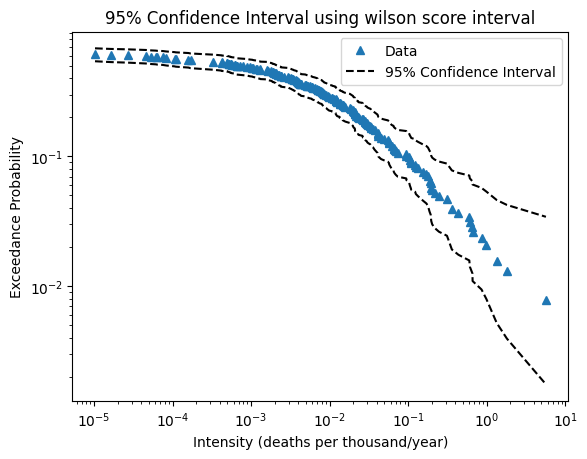

In [13]:
# line plot of lower and upper bounds of the 95% confidence interval
fig, ax = plt.subplots()
ax.plot(wilson_df['intensity'], wilson_df['exceedance_probs'], '^', markersize=6)
ax.plot(wilson_df['intensity'], wilson_df['lowers'], color='black', linestyle='dashed')
ax.plot(wilson_df['intensity'], wilson_df['uppers'], color='black', linestyle='dashed')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "95% Confidence Interval"])
ax.set_title("95% Confidence Interval using wilson score interval")
plt.show()

Text(0.5, 1.0, 'approximate distribution of estimates of GPD parameters')

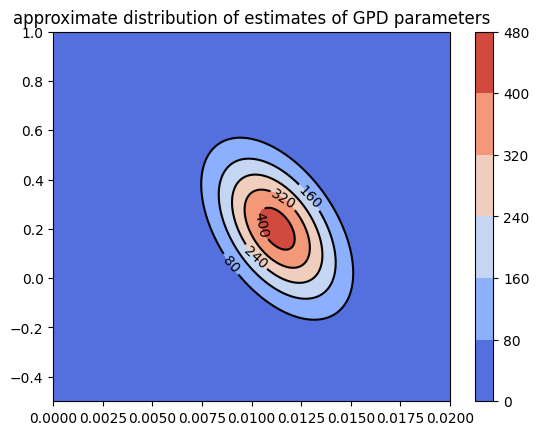

In [14]:
# we approximate the distribution of the MLEs as a bivariate normal distribution
from scipy.stats import multivariate_normal as mvn

dist = mvn( mean=[scale_mle,shape_se], cov=covariance_matrix )

xlim = (-0.0,0.02)
ylim = (-0.5,1)
  
x = np.linspace(*xlim,1000)
y = np.linspace(*ylim,1000)

X, Y = np.meshgrid(x,y)
pos = np.dstack( (X,Y) )
Z = dist.pdf(pos)

# for illustration purposes
fig, ax = plt.subplots()
im = ax.contourf(X,Y,Z,levels=5,cmap='coolwarm')
cs = ax.contour(X,Y,Z,levels = 5, colors='k')
plt.clabel(cs, cs.levels, inline=True)
plt.colorbar(im)
plt.title('approximate distribution of estimates of GPD parameters')

In [32]:
# find lower and upper bounds of the scale and shape parameters for 95% confidence interval
# this values change from run to run
x = "Intensity (deaths per thousand/year)"
data = sorted_data
scale_above, scale_below, shape_above, shape_below = find_gpd_bounds(x, data, scale_mle, shape_mle, scale_se, shape_se, 
                                                                     covariance_matrix, n_simulations = 10000, n_bootstrap = 1000)

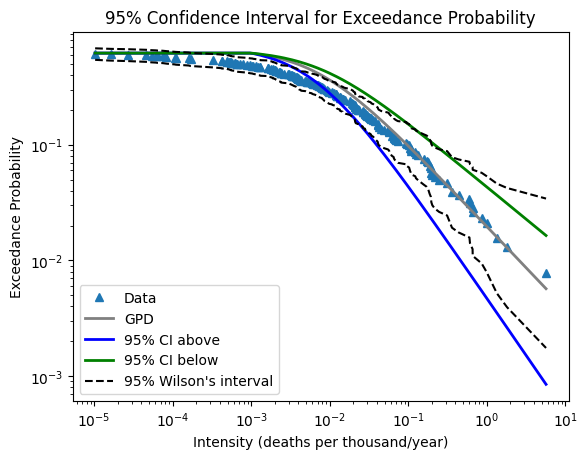

In [33]:
# plot 2 CIs together
gpd_values_above = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=0.001, sigma=scale_above, xi=shape_above)
gpd_values_below = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=0.001, sigma=scale_below, xi=shape_below)
fig, ax = plt.subplots()
ax.plot(wilson_df['intensity'], wilson_df['exceedance_probs'], '^', markersize=6)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62, color='gray', linewidth=2)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], gpd_values_above*0.62, color='blue', linewidth=2)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], gpd_values_below*0.62, color='green', linewidth=2)
ax.plot(wilson_df['intensity'], wilson_df['lowers'], color='black', linestyle='dashed')
ax.plot(wilson_df['intensity'], wilson_df['uppers'], color='black', linestyle='dashed')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data","GPD", "95% CI above", "95% CI below", "95% Wilson's interval"])
ax.set_title("95% Confidence Interval for Exceedance Probability")
plt.show()

### Interval estimation for the expected number of deaths from natural pandemics this centry

In [25]:
population = params.Global.population.val
max_intensity = params.Natural.max_intensity.val
vaccines_multiplier = params.Natural.vaccines_multiplier.val

intensities= np.linspace(0.001, max_intensity, 1000)
gpd_values = compute_gpd(intensities, mu = 0.001, sigma = scale_mle, xi = shape_mle)
gpd_values_above = compute_gpd(intensities, mu = 0.001, sigma = scale_above, xi = shape_above)
gpd_values_below = compute_gpd(intensities, mu = 0.001, sigma = scale_below, xi = shape_below)
expected_yearly_intensity = np.trapz(intensities * gpd_values, intensities) * vaccines_multiplier
expected_yearly_intensity_above = np.trapz(intensities * gpd_values_above, intensities) * vaccines_multiplier
expected_yearly_intensity_below = np.trapz(intensities * gpd_values_below, intensities) * vaccines_multiplier
E_natural_deaths_annual = expected_yearly_intensity * (population / 1e3)
E_natural_deaths_annual_above = expected_yearly_intensity_above * (population / 1e3)
E_natural_deaths_annual_below = expected_yearly_intensity_below * (population / 1e3)

In [26]:
num_years = params.Global.num_years.val
E_natural_deaths = E_natural_deaths_annual * num_years
E_natural_deaths_above = E_natural_deaths_annual_above * num_years
E_natural_deaths_below = E_natural_deaths_annual_below * num_years

display_text(f"Expected number of deaths from natural epidemics this century = <strong>{E_natural_deaths/1e6:.1f} million deaths</strong>")
display_text(f"95% Confidence Interval: <strong>{E_natural_deaths_below/1e6:.1f} million deaths</strong> to <strong>{E_natural_deaths_above/1e6:.1f} million deaths</strong>")